# Using the Custom Hardware Image Generator

This notebook demonstrates hardware generation of an image stream and displaying it on the HDMI output. Before running it you will need to compile the example overlay with the frame generator in Verilog. Two files are generated:
- a `.bit` file, containing the FPGA configuration bitstream
- a `.hwh` (hardware handoff) file, containing information about the module heirarchy and memory map

Copy both files to the user home directory on the Pynq operating system. Then load them (loading the `.bit` also reads the `.hwh` of the same name):

In [12]:
from pynq import Overlay
from pynq.lib.video import *

overlay = Overlay("/home/xilinx/multi_engine_5_3.bit")

#pixgen.register_map.gp0 = 0x1234
#print(pixgen.register_map.gp0)

# Which registers holding which pixels // gpo: zoom, gp1: max_iter, gp2: x_offset, gp3: y_offset 






RuntimeError: no validator found for <class 'object'>, see `arbitrary_types_allowed` in Config

In [11]:
import nest_asyncio
nest_asyncio.apply()

In [10]:
!pip uninstall fastapi starlette uvicorn typing_extensions pydantic anyio exceptiongroup -y
!pip install --no-deps "fastapi==0.68.0" "starlette==0.14.2" "uvicorn==0.15.0" "pydantic==1.8.2" --force-reinstall
!pip install typing_extensions

Found existing installation: fastapi 0.68.0
Uninstalling fastapi-0.68.0:
  Successfully uninstalled fastapi-0.68.0
Found existing installation: starlette 0.14.2
Uninstalling starlette-0.14.2:
  Successfully uninstalled starlette-0.14.2
Found existing installation: uvicorn 0.15.0
Uninstalling uvicorn-0.15.0:
  Successfully uninstalled uvicorn-0.15.0
Found existing installation: typing_extensions 4.14.0
Uninstalling typing_extensions-4.14.0:
  Successfully uninstalled typing_extensions-4.14.0
  Using cached fastapi-0.68.0-py3-none-any.whl (52 kB)
  Using cached starlette-0.14.2-py3-none-any.whl (60 kB)
  Using cached uvicorn-0.15.0-py3-none-any.whl (54 kB)
  Using cached pydantic-1.8.2-py3-none-any.whl (126 kB)
  Using cached typing_extensions-4.14.0-py3-none-any.whl (43 kB)


In [8]:

import asyncio
import websockets
import json
import threading
from qformatpy import qformat
from pynq import Overlay
from pynq.lib.video import *
import PIL.Image
from io import BytesIO
import base64

# Install websockets if needed
try:
    import websockets
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "websockets"])
    import websockets

# PYNQ Setup
# overlay = Overlay("/home/xilinx/32_bit_zoom_2.bit")
imgen_vdma = overlay.video.axi_vdma_0.readchannel
pixgen = overlay.pixel_generator_0

videoMode = common.VideoMode(640, 480, 24)
imgen_vdma.mode = videoMode
imgen_vdma.start()

def generate_frame_with_params(params):
    # Convert to Q4.28 format
    re_c_q = qformat(params.get('re_c', -0.5), 4, 28)
    im_c_q = qformat(params.get('im_c', 0.0), 4, 28)
    
    # Set FPGA registers
    pixgen.register_map.gp0 = params.get('max_iter', 200)       
    pixgen.register_map.gp1 = int(params.get('zoom', 1))            
    pixgen.register_map.gp2 = re_c_q   
    pixgen.register_map.gp3 = im_c_q

    # Generate frame
    frame = imgen_vdma.readframe()
    image = PIL.Image.fromarray(frame)
    im_file = BytesIO()
    image.save(im_file, format='PNG')

    # Return base64 data URI
    im_b64_string = base64.b64encode(im_file.getvalue()).decode('utf-8')
    return f"data:image/png;base64,{im_b64_string}"

async def handle_websocket(websocket, path):
    print(f"Client connected from {websocket.remote_address}")
    try:
        async for message in websocket:
            try:
                params = json.loads(message)
                print(f"Received params: {params}")
                
                # Generate frame with FPGA
                base_rep = generate_frame_with_params(params)
                
                # Send back to client
                await websocket.send(base_rep)
                print("Sent fractal image to client")
                
            except json.JSONDecodeError as e:
                print(f"JSON decode error: {e}")
                await websocket.send(json.dumps({"error": "Invalid JSON"}))
            except Exception as e:
                print(f"Error processing message: {e}")
                await websocket.send(json.dumps({"error": str(e)}))
                
    except websockets.exceptions.ConnectionClosed:
        print("Client disconnected")
    except Exception as e:
        print(f"WebSocket error: {e}")

def start_websocket_server():
    # Create new event loop for this thread
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    
    # Start server on port 8000 (no routing needed)
    start_server = websockets.serve(handle_websocket, "0.0.0.0", 8000)
    loop.run_until_complete(start_server)
    print("WebSocket server running on ws://192.168.137.175:8000")
    loop.run_forever()

# Start server in background thread
server_thread = threading.Thread(target=start_websocket_server, daemon=True)
server_thread.start()

print("Starting WebSocket server...")
print("Server will be available at ws://192.168.137.175:8000")
print("No /websocket endpoint needed - connect directly to ws://192.168.137.175:8000")

# Keep the cell running
import time
time.sleep(2)
print("✅ WebSocket server is running!")

RuntimeError: no validator found for <class 'object'>, see `arbitrary_types_allowed` in Config

In [44]:
# Test cell - run this to check if server is working
import requests
import socket

# Test if port 8000 is open
def test_port(host, port):
    try:
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.settimeout(5)
        result = sock.connect_ex((host, port))
        sock.close()
        return result == 0
    except:
        return False

print(f"Port 8000 open on localhost: {test_port('localhost', 8000)}")
print(f"Port 8000 open on 192.168.137.175: {test_port('192.168.137.175', 8000)}")

# Test if any process is using port 8000
import subprocess
try:
    result = subprocess.run(['netstat', '-tulpn'], capture_output=True, text=True)
    lines = result.stdout.split('\n')
    port_8000_lines = [line for line in lines if ':8000' in line]
    if port_8000_lines:
        print("Processes using port 8000:")
        for line in port_8000_lines:
            print(line)
    else:
        print("❌ No process found using port 8000")
except:
    print("Could not check netstat")

Port 8000 open on localhost: True
Port 8000 open on 192.168.137.175: True
Processes using port 8000:
tcp        0      0 0.0.0.0:8000            0.0.0.0:*               LISTEN      1190/python3        
Client connected from ('192.168.137.1', 53361)
Received params: {'re_c': -0.5, 'im_c': 0, 'zoom': 1, 'max_iter': 200, 'colour_sch': 'classic'}
Sent fractal image to client


The overlay object is automatically configured with a Python attribute structure that allows you to access the hardware as Python objects. Appropriate driver classes are instantiated where a hardware block is recognised by the Pynq library. Here we get a convenient handle to the VDMA connected to the pixel generator:

In [23]:
imgen_vdma = overlay.video.axi_vdma_0.readchannel

Next, the image generator DMA is configured and started:

In [24]:
videoMode = common.VideoMode(640, 480, 24)
imgen_vdma.mode = videoMode
imgen_vdma.start()

The VDMA continuously reads frames into a cycle of memory buffers. You can take software ownership of a frame and get a NumPy handle for it:

In [4]:
# Optional Debugging

print("Running:", imgen_vdma.running)
print("Started:", imgen_vdma.readchannel.running)
print("State:", imgen_vdma.readchannel.state)

Running: True


AttributeError: 'S2MMChannel' object has no attribute 'readchannel'

The frame can be displayed in the notebook using PiL:

In [23]:
# Ed Stott test code

from pynq import Overlay
from pynq.lib.video import *
import PIL.Image

overlay = Overlay("/home/xilinx/Kevin's_attempt.bit")
pg_vdma = overlay.video.axi_vdma_0
videoMode = common.VideoMode(640, 480, 24)
pg_vdma.readchannel.mode = videoMode
pg_vdma.readchannel.start()

frame = pg_vdma.readchannel.readframe()
image = PIL.Image.fromarray(frame)
image



KeyboardInterrupt



In [36]:
import numpy as np
from PIL import Image

def rgb_to_intensity(image_array):
    """Convert RGB image to intensity (grayscale)"""
    # Handle both PIL format [(r,g,b), ...] and numpy array format
    if len(image_array.shape) == 3:
        # Standard numpy array format (height, width, channels)
        weights = np.array([0.299, 0.587, 0.114])
        return np.dot(image_array[...,:3], weights)
    else:
        # If it's already grayscale, return as-is
        return image_array

def intensity_to_rainbow(intensity):
    """Convert intensity values to rainbow color scheme"""
    # Ensure intensity is a numpy array
    intensity = np.asarray(intensity)
    
    # Normalize intensity to 0-1 range
    normalized = intensity / 255.0
    
    # Create rainbow using HSV where hue varies with intensity
    # Hue: 0 (red) to 300 (magenta), avoiding full circle to prevent red repetition
    hue = normalized * 300  # degrees
    saturation = np.ones_like(normalized)  # Full saturation
    value = np.ones_like(normalized)  # Full brightness
    
    # Convert HSV to RGB
    c = value * saturation
    x = c * (1 - np.abs(((hue / 60) % 2) - 1))
    m = value - c
    
    # Initialize RGB arrays
    r = np.zeros_like(hue)
    g = np.zeros_like(hue)
    b = np.zeros_like(hue)
    
    # Assign RGB values based on hue sector
    mask1 = (hue >= 0) & (hue < 60)
    r[mask1] = c[mask1]
    g[mask1] = x[mask1]
    
    mask2 = (hue >= 60) & (hue < 120)
    r[mask2] = x[mask2]
    g[mask2] = c[mask2]
    
    mask3 = (hue >= 120) & (hue < 180)
    g[mask3] = c[mask3]
    b[mask3] = x[mask3]
    
    mask4 = (hue >= 180) & (hue < 240)
    g[mask4] = x[mask4]
    b[mask4] = c[mask4]
    
    mask5 = (hue >= 240) & (hue < 300)
    r[mask5] = x[mask5]
    b[mask5] = c[mask5]
    
    mask6 = hue >= 300
    r[mask6] = c[mask6]
    b[mask6] = x[mask6]
    
    # Add the minimum component and convert to 0-255 range
    r = np.clip((r + m) * 255, 0, 255)
    g = np.clip((g + m) * 255, 0, 255)
    b = np.clip((b + m) * 255, 0, 255)
    
    return np.stack([r, g, b], axis=-1).astype(np.uint8)

def intensity_to_fire(intensity):
    """Convert intensity values to fire color scheme (black -> red -> orange -> yellow -> white)"""
    intensity = np.asarray(intensity)
    
    # Normalize to 0-1
    normalized = intensity / 255.0
    
    r = np.zeros_like(normalized)
    g = np.zeros_like(normalized)
    b = np.zeros_like(normalized)
    
    # Black to red (0 to 0.25)
    mask1 = normalized <= 0.25
    r[mask1] = normalized[mask1] * 4
    
    # Red to orange (0.25 to 0.5)
    mask2 = (normalized > 0.25) & (normalized <= 0.5)
    r[mask2] = 1.0
    g[mask2] = (normalized[mask2] - 0.25) * 4
    
    # Orange to yellow (0.5 to 0.75)
    mask3 = (normalized > 0.5) & (normalized <= 0.75)
    r[mask3] = 1.0
    g[mask3] = 1.0
    b[mask3] = (normalized[mask3] - 0.5) * 4
    
    # Yellow to white (0.75 to 1.0)
    mask4 = normalized > 0.75
    r[mask4] = 1.0
    g[mask4] = 1.0
    b[mask4] = 0.5 + (normalized[mask4] - 0.75) * 2
    
    return np.stack([r * 255, g * 255, b * 255], axis=-1).astype(np.uint8)

def intensity_to_ocean(intensity):
    """Convert intensity values to ocean color scheme (deep blue -> cyan -> light blue -> white)"""
    intensity = np.asarray(intensity)
    
    # Normalize to 0-1
    normalized = intensity / 255.0
    
    r = np.zeros_like(normalized)
    g = np.zeros_like(normalized)
    b = np.zeros_like(normalized)
    
    # Deep blue to blue (0 to 0.33)
    mask1 = normalized <= 0.33
    r[mask1] = 0.0
    g[mask1] = normalized[mask1] * 0.9  # Fixed to not exceed 1.0
    b[mask1] = np.clip(0.5 + normalized[mask1] * 1.5, 0, 1)  # Clipped to valid range
    
    # Blue to cyan (0.33 to 0.66)
    mask2 = (normalized > 0.33) & (normalized <= 0.66)
    progress = (normalized[mask2] - 0.33) / 0.33
    r[mask2] = 0.0
    g[mask2] = 0.1 + progress * 0.9
    b[mask2] = 1.0
    
    # Cyan to white (0.66 to 1.0)
    mask3 = normalized > 0.66
    progress = (normalized[mask3] - 0.66) / 0.34
    r[mask3] = progress
    g[mask3] = 1.0
    b[mask3] = 1.0
    
    return np.stack([r * 255, g * 255, b * 255], axis=-1).astype(np.uint8)

def intensity_to_grayscale(intensity):
    """Convert intensity values to grayscale (identity function but returns RGB format)"""
    intensity = np.asarray(intensity)
    gray = intensity.astype(np.uint8)
    return np.stack([gray, gray, gray], axis=-1)

def intensity_to_classic_wolfram(intensity):
    """Convert intensity values to classic Wolfram color scheme (purple -> blue -> cyan -> green -> yellow -> red)"""
    intensity = np.asarray(intensity)
    
    # Normalize to 0-1
    normalized = intensity / 255.0
    
    # Define color stops for classic Wolfram scheme
    # This creates a spectral-like mapping similar to Mathematica's default
    r = np.zeros_like(normalized)
    g = np.zeros_like(normalized)
    b = np.zeros_like(normalized)
    
    # Purple to blue (0 to 0.2)
    mask1 = normalized <= 0.2
    progress = normalized[mask1] / 0.2
    r[mask1] = 0.5 - progress * 0.5
    g[mask1] = 0.0
    b[mask1] = 0.5 + progress * 0.5
    
    # Blue to cyan (0.2 to 0.4)
    mask2 = (normalized > 0.2) & (normalized <= 0.4)
    progress = (normalized[mask2] - 0.2) / 0.2
    r[mask2] = 0.0
    g[mask2] = progress
    b[mask2] = 1.0
    
    # Cyan to green (0.4 to 0.6)
    mask3 = (normalized > 0.4) & (normalized <= 0.6)
    progress = (normalized[mask3] - 0.4) / 0.2
    r[mask3] = 0.0
    g[mask3] = 1.0
    b[mask3] = 1.0 - progress
    
    # Green to yellow (0.6 to 0.8)
    mask4 = (normalized > 0.6) & (normalized <= 0.8)
    progress = (normalized[mask4] - 0.6) / 0.2
    r[mask4] = progress
    g[mask4] = 1.0
    b[mask4] = 0.0
    
    # Yellow to red (0.8 to 1.0)
    mask5 = normalized > 0.8
    progress = (normalized[mask5] - 0.8) / 0.2
    r[mask5] = 1.0
    g[mask5] = 1.0 - progress
    b[mask5] = 0.0
    
    return np.stack([r * 255, g * 255, b * 255], axis=-1).astype(np.uint8)

def apply_colormap_to_pil(pil_image, colormap_function):
    # Convert PIL image to numpy array
    img_array = np.array(pil_image)
    
    # Convert to intensity if needed
    if len(img_array.shape) == 3 and img_array.shape[2] >= 3:
        # RGB or RGBA image - convert to intensity
        intensity = rgb_to_intensity(img_array)
    else:
        # Already grayscale
        intensity = img_array
    
    # Apply colormap
    colored_array = colormap_function(intensity)
    
    # Convert back to PIL Image
    return Image.fromarray(colored_array, 'RGB')

# Convenience functions for direct PIL usage
def pil_to_rainbow(pil_image):
    return apply_colormap_to_pil(pil_image, intensity_to_rainbow)

def pil_to_fire(pil_image):
    return apply_colormap_to_pil(pil_image, intensity_to_fire)

def pil_to_grayscale(pil_image):
    return apply_colormap_to_pil(pil_image, intensity_to_grayscale)

def pil_to_wolfram(pil_image):
    return apply_colormap_to_pil(pil_image, intensity_to_classic_wolfram)


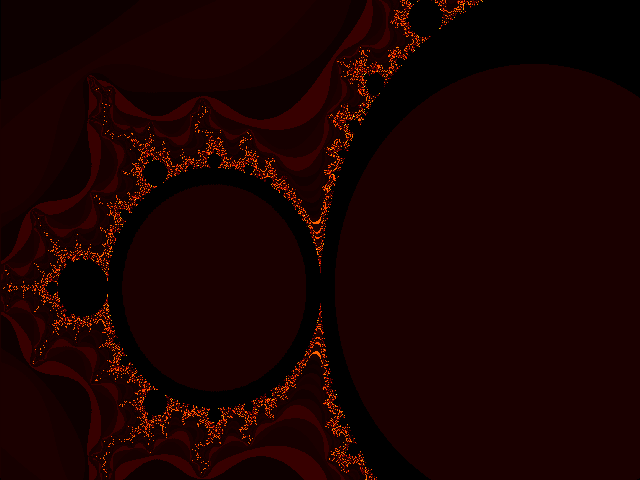

In [38]:
import PIL.Image

frame = imgen_vdma.readframe()
image = PIL.Image.fromarray(frame)
#print(frame)
image = pil_to_fire(image)
image



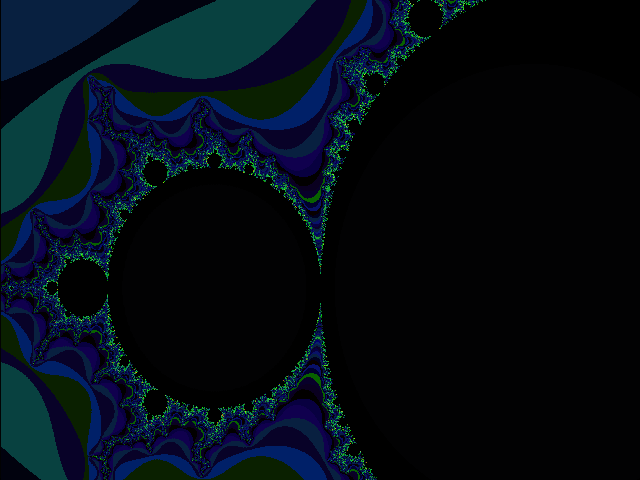

In [11]:
from io import BytesIO
import base64

def conv_to_b64(image):
    im_file = BytesIO()
    image.save(im_file, format='PNG')


    im_b64_string = base64.b64encode(im_file.getvalue()).decode('utf-8')
    data_url = f"data:image/jpeg;base64,{im_b64_string}"
    print(data_url)
    
conv_to_b64(image)

Matplotlib is building the font cache; this may take a moment.


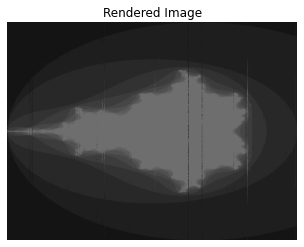

Saved to image_pixels.csv


/home/xilinx/jupyter_notebooks/image_pixels.csv

In [19]:
import PIL.Image
import numpy as np
import csv
import os

# Optional: Display inline image
from IPython.display import display, FileLink
import matplotlib.pyplot as plt

# --- Load or define the frame ---
# Assuming `frame` is already a NumPy array
image = PIL.Image.fromarray(frame)
pixels = np.array(image)

# Optional display
plt.imshow(image)
plt.title("Rendered Image")
plt.axis('off')
plt.show()

# --- Save as CSV ---
output_csv = "image_pixels.csv"

with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    if pixels.ndim == 2:  # Grayscale
        for row in pixels:
            writer.writerow(row.tolist())

    elif pixels.ndim == 3 and pixels.shape[2] == 3:  # RGB
        for row in pixels:
            writer.writerow([f"{r},{g},{b}" for r, g, b in row])

    else:
        raise ValueError("Unsupported image shape")

print(f"Saved to {output_csv}")

# --- Show download link in Jupyter ---
display(FileLink(output_csv))




### HDMI Output
The HDMI output is handled with a wrapper object that configures both the VDMA and the HDMI output generator.

A bit of hacking is needed here: the image generator and its VDMA are in the same part of the design hierarchy (`video`) as the HDMI interface. The HDMI output wrapper `overlay.video.hdmi_out` picks up the image generator VDMA, not the one connected to HDMI, so that attribute needs to be changed to point to the correct VDMA.

After that, the HDMI output is configured and started:

In [27]:
hdmi_out = overlay.video.hdmi_out
hdmi_out._vdma = overlay.video.axi_vdma #Use the correct VDMA!
hdmi_out.configure(videoMode)
hdmi_out.start()

Now our frame can be sent to the HDMI output. At this stage ownership of the frame is transferred to the hardware, so it's no longer accessible to Python code. Connect a display to the HDMI port and you should see it.

In [28]:
# while True:
#     frame = imgen_vdma.readframe()
hdmi_out.writeframe(frame)

### MMIO Interface with Pixel Generator
You'll need to pass parameters to your image generator to change the visualisation at runtime. This is done with memory-mapped input/output, which allows software to modify registers in the logic. First get a handle to the Pixel Generator block and print its dictionary of registers:

In [ ]:
pixgen = overlay.pixel_generator_0
pixgen.register_map

In [41]:
frame

PynqBuffer([[[ 0,  0,  0],
             [ 8, 32,  0],
             [ 8, 32,  0],
             ...,
             [ 0,  0,  0],
             [ 0,  0,  0],
             [ 0,  0,  0]],

            [[ 0,  0,  0],
             [ 8, 32,  0],
             [ 8, 32,  0],
             ...,
             [ 0,  0,  0],
             [ 0,  0,  0],
             [ 0,  0,  0]],

            [[ 0,  0,  0],
             [ 8, 32,  0],
             [ 8, 32,  0],
             ...,
             [ 0,  0,  0],
             [ 0,  0,  0],
             [ 0,  0,  0]],

            ...,

            [[ 8,  2,  8],
             [ 8,  2,  8],
             [ 8,  2,  8],
             ...,
             [ 8,  2,  8],
             [ 8,  2,  8],
             [ 8,  2,  8]],

            [[ 0,  0,  0],
             [ 8,  2,  8],
             [ 8,  2,  8],
             ...,
             [ 8,  2,  8],
             [ 8,  2,  8],
             [ 0,  0,  0]],

            [[ 0,  0,  0],
             [ 8,  2,  8],
             [ 8, 

The registers can be modified directly as Python objects

In [ ]:
import PIL.Image
import time

# pixgen.register_map.gp0 = 0x10
# print(pixgen.register_map.gp0)

# Which registers holding which pixels // gpo: zoom, gp1: max_iter, gp2: x_offset, gp3: y_offset 

pixgen = overlay.pixel_generator_0
# pixgen.register_map

max_iter = 0x00C8
zoom = 0x0002
real_center = 0xF4000000
imag_center = 0x0199999A
zoom_reciprocal = 134217728 / 256
max_iter_reciprocal = 65536 // max_iter

pixgen.register_map.gp0 = max_iter
pixgen.register_map.gp1 = zoom
pixgen.register_map.gp2 = real_center
pixgen.register_map.gp3 = imag_center
pixgen.register_map.gp4 = zoom_reciprocal
pixgen.register_map.gp5 = max_iter_reciprocal

num_steps = 1000

for i in range (1,num_steps):
    frame = imgen_vdma.readframe()
    image = PIL.Image.fromarray(frame)
    hdmi_out.writeframe(frame)
    #zoom_rec = i
#     conv_to_b64(filtered_image)
    
#     frame = imgen_vdma.readframe()
#     image = PIL.Image.fromarray(frame)
#     filtered_image = pil_to_rainbow(image)
#     filtered_array = np.array(filtered_image)

#     # Copy the filtered data back into the original frame buffer
#     frame[:] = filtered_array  # This modifies the original frame object in-place

#     hdmi_out.writeframe(frame)  # Now writes the filtered frame
#     conv_to_b64(filtered_image)
    
   # pixgen.register_map.gp1 = i

In [ ]:
# SERVER CODE - Continuous streaming
import socket
import json
import numpy as np
import time

server_port = 12000
welcome_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
welcome_socket.bind(('0.0.0.0', server_port))
welcome_socket.listen(1)

print('Streaming server running on port', server_port)

while True:
    connection_socket, caddr = welcome_socket.accept()
    print(f"Streaming to {caddr}")
    
    try:
        # Send arrays continuously
        for i in range(100):  # Send 100 arrays
            # Generate changing data (simulate FPGA readings)
            numpy_array = np.random.rand(2, 3) * (i + 1)
            
            array_data = {
                'array': numpy_array.tolist(),
                'shape': numpy_array.shape,
                'dtype': str(numpy_array.dtype),
                'sequence': i
            }
            
            json_data = json.dumps(array_data) + '\n'  # Add newline delimiter
            connection_socket.send(json_data.encode())
            
            print(f"Sent array {i+1}/100")
           # time.sleep(0.5)  # Send every 0.5 seconds
            
    except Exception as e:
        print(f"Client disconnected: {e}")
    finally:
        connection_socket.close()

# CLIENT CODE - Receive streaming data
import socket
import json
import numpy as np

client_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
client_socket.connect(('192.168.1.100', 12000))

print("Receiving streaming data...")

buffer = ""
try:
    while True:
        data = client_socket.recv(1024).decode()
        if not data:
            break
            
        buffer += data
        
        # Process complete JSON messages (delimited by newlines)
        while '\n' in buffer:
            line, buffer = buffer.split('\n', 1)
            
            try:
                array_data = json.loads(line)
                numpy_array = np.array(array_data['array'])
                seq = array_data['sequence']
                
                print(f"Array {seq+1}: shape={numpy_array.shape}, mean={numpy_array.mean():.2f}")
                
            except json.JSONDecodeError:
                continue
                
except KeyboardInterrupt:
    print("\nStopping...")
finally:
    client_socket.close()

Streaming server running on port 12000


Data that you write to register `n` is is available in `regfile[n]` in your logic

### Cleanup
Finally, stop the VDMAs so that the system is in a stable state at the end of the notebook

In [3]:
imgen_vdma.stop()
hdmi_out.close()

NameError: name 'imgen_vdma' is not defined

Todo:
- [ ] Copy multiple frames and find frame rate
- [ ] Link input and output for continuous video output without software control